# Train a regressor on a set of embeddings of tweet texts

Use **GetOldTweets3** library (available via Pypi)

## Install required libraries

In [1]:
# !pip install GetOldTweets3
import GetOldTweets3 as got

In [2]:
# !pip install basilica # might have to install, if not available in underlying environment

In [3]:
import pandas as pd
# import json
import numpy as np
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.decomposition
import basilica
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Configure

In [4]:
twitter_user_name = 'LambdaSchool'
count = 100 # during testing
API_KEY =  'd54eac04-1ed6-3d8d-8a46-b319018f2faa'

os.getcwd()

'/home/gt/gitstuff/cuddly-robot'

## Data Engineering Functions

In [5]:
def retrieve_tweets(twitter_user_name, count):
    #  Create object to execute queries
    querySpecs = got.manager.TweetCriteria().setUsername(twitter_user_name).setMaxTweets(count)
    print('Retrieving tweets via GOT3')
    # retrieve tweets
    return got.manager.TweetManager.getTweets(querySpecs)

def tweet_to_dict(twt):
    """Munges a twt object into a dict, using names of attributes of
    object as keys in dict.
    'favorites' is a count of 'likes'
    'hashtags' is a string that is a space-separated series of hashtags
    'mentions' is a string that is a space-separated series of ats (@s)
    'urls' is a string that is a space-separated series of URLs
    """
    return {'date' : twt.date
            , 'favorites' : twt.favorites
            , 'formatted_date' : twt.formatted_date
            , 'geo' : twt.geo
            , 'hashtags' : twt.hashtags
            , 'id' : twt.id
            , 'mentions' : twt.mentions
            , 'permalink' : twt.permalink
            , 'replies' : twt.replies
            , 'retweets' : twt.retweets
            , 'text' : twt.text
            , 'to' : twt.to
            , 'urls' : twt.urls
            , 'username' : twt.username}   

def munge_date(dt):
    """Munges a datetime.datetime object into a dict, using names of attributes of
    object as keys in dict.
    'day_of_week' is [0-7] with 0 being 'Monday'
    'minute_of_day' is count of minutes from midnight"""
    return {'year' : dt.year 
            , 'month' : dt.month
            , 'day' : dt.day
            , 'day_of_week' : dt.weekday()
            , 'hour' : dt.hour
            , 'minute' : dt.minute
            , 'minute_of_day' : (60 * dt.hour) + dt.minute}

def join_dicts(got_tweet_object):
    """Returns a dict that is the result of joining 
    - a dict that is the result of parsing a GOT object
      to  dict, and
    - a dict that is the result of munging the a datetime.date
      into a dict."""
    return {**tweet_to_dict(got_tweet_object), **munge_date(got_tweet_object.date)}

def munge_tweet_objects(tweet_objects):
    return list(map(join_dicts, tweet_objects))


In [6]:
# get a set of tweets
pickled_fn = './r_tweets.pickle'
pickled_path = Path(pickled_fn)

# pickled_path.is_file()


In [9]:
retrieved_tweets = retrieve_tweets(twitter_user_name, count)
tweet_dicts = munge_tweet_objects(retrieved_tweets)

# create a df of embeddings of the texts

# get texts for which to get embeddings
tweet_texts = [tweet.text for tweet in retrieved_tweets]

# get embeddings
print('retrieving embeddings via basilica')
with basilica.Connection(API_KEY) as conn:
    embeddings = list(conn.embed_sentences(tweet_texts))

# create dataframe holding embeddings
embedding_vals_colnames = ['embed_col' + str(i) for i in range(len(embeddings[0]))]
embeddings_df = pd.DataFrame(embeddings, columns=embedding_vals_colnames)

# Define columns to be excluded from the dataframe.
# Datetime fields used to calculate minute of day and day of week are no longer needed.
# I do not drop retweets or favorites because they will be target.
columns_not_needed = ['id', 'hashtags', 'replies', 'text', 'mentions', 'to', 'urls', 
                      'year', 'month', 'day', 'date', 'formatted_date', 'permalink', 
                      'username', 'hour', 'minute', 'geo']

times_df = pd.DataFrame.from_records(tweet_dicts,  exclude=columns_not_needed)

merged_df = pd.concat([times_df, embeddings_df], axis=1)
merged_df.head()


Retrieving tweets via GOT3
retrieving embeddings via basilica


,favorites,retweets,day_of_week,minute_of_day,embed_col0,embed_col1,embed_col2,embed_col3,embed_col4,embed_col5,...,embed_col758,embed_col759,embed_col760,embed_col761,embed_col762,embed_col763,embed_col764,embed_col765,embed_col766,embed_col767
0,13,2,6,51,0.452121,-0.152460,0.363199,0.197211,0.167632,-0.398828,...,0.053072,-0.168918,-0.249199,-0.249775,0.083183,0.219856,-0.465787,-0.065341,0.055628,0.656874
1,10,0,5,1080,0.333295,-0.058294,0.369082,0.374916,0.238671,-0.308427,...,0.048098,-0.260205,-0.238626,-0.237041,0.285211,0.211573,-0.315337,-0.118808,0.053902,0.290706
2,3,0,5,971,0.283399,0.249766,0.380451,0.107287,-0.151868,-0.390896,...,0.003423,-0.163032,0.009421,0.070432,0.386311,0.162242,-0.557908,-0.074896,-0.015374,0.050820
3,7,2,4,1380,0.091492,-0.362984,0.255111,0.365398,0.142696,-0.480672,...,0.129827,-0.281333,-0.046512,-0.457974,0.021936,0.079506,-0.301939,0.104239,0.258840,0.517581
4,13,9,4,937,0.354484,-0.268105,0.173120,0.189463,0.216159,-0.592189,...,-0.031987,0.018888,-0.322313,-0.274837,0.212215,0.537017,-0.423740,-0.006413,0.204176,0.402765


## Split into X matrix and y vectors

In [24]:
# use PowerTransformer to remove right skew in target data
from sklearn.preprocessing import power_transform
def transform(vector):
    return power_transform(vector.reshape(-1, 1), method='yeo-johnson')

In [26]:
y_vector_likes = merged_df['favorites'].fillna(0).values
y_vector_likes_transformed = transform(y_vector_likes)
# y_vector_likes[:5]

y_vector_retweets = merged_df['retweets'].fillna(0).values
y_vector_retweets_transformed = transform(y_vector_retweets)
# y_vector_retweets[:5]

array([2, 0, 0, 2, 9])

In [27]:
X_matrix = merged_df.drop(columns=['favorites', 'retweets']).values
len(X_matrix[0])

770

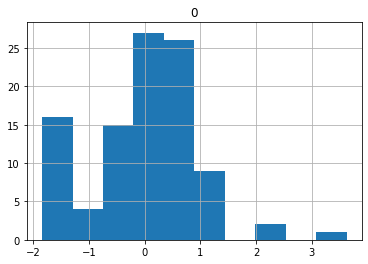

In [33]:
pd.DataFrame(y_vector_likes_transformed).hist();

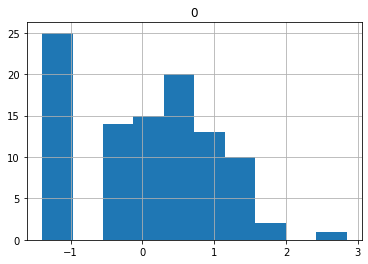

In [32]:
pd.DataFrame(y_vector_retweets_transformed).hist();

## Training Regressors

In [34]:
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.model_selection

In [36]:
X_train, X_test = sklearn.model_selection.train_test_split(X_matrix, random_state=72)

In [37]:
y_retweets_train, y_retweets_test = sklearn.model_selection.train_test_split(y_vector_retweets, random_state=72)

In [38]:
y_likes_train, y_likes_test = sklearn.model_selection.train_test_split(y_vector_likes, random_state=72)

In [69]:
retweets_model = sklearn.linear_model.LogisticRegression(max_iter=5000)

# print(type(y_likes_train))
# print(type(y_likes_train.values))
# print(type(y_likes_train.values[0]))

retweets_model.fit(X_train, y_retweets_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
likes_model = sklearn.linear_model.LogisticRegression(max_iter=10000)

likes_model.fit(X_train, y_likes_train)
# X_train

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
# likes_model

# with open('likes_model.pikl', 'wb') as f:
#         pickle.dump(likes_model, f)

# with open('likes_model.pikl', 'rb') as f:
#     likes_model2 = pickle.load(f)
    
# likes_model2

## Results

In [73]:
print('Retweets Train accuracy: %.3f' % retweets_model.score(X_train, y_retweets_train))
print('Retweets Test accuracy: %.3f' % retweets_model.score(X_test, y_retweets_test))

print('Likes Train accuracy: %.3f' % likes_model.score(X_train, y_likes_train))
print('Likes Test accuracy: %.3f' % likes_model.score(X_test, y_likes_test))

Retweets Train accuracy: 1.000
Retweets Test accuracy: 0.360
Likes Train accuracy: 1.000
Likes Test accuracy: 0.160


In [ ]:
# y_retweets[0:10]

In [94]:
def predict_one_from_X_matrix(model, idx):
    """Return a prediction, from a specified model, for
    a set of observations from the X_matrix."""
    return model.predict([X_matrix[idx]])[0]

predict_one_from_X_matrix(retweets_model, 0)

predict_one_from_X_matrix(likes_model, 0)

# tweet_texts[0]

'"It\'s times like these that make me feel blessed to have gone to K-12 in high school, and Lambda School today. E-Learning is the future of quality, custom-tailored education," shares Lambda student Kenneth Barrett. Apply now: https://bit.ly/36G5Bmn #FutureOfEducation'

In [107]:
def get_one_embedding(txt):
    with basilica.Connection(API_KEY) as conn:
        mbdg = conn.embed_sentence(txt)
    return mbdg 

# my_mbdng = get_one_embedding("This is a test tweet")
# my_mbdng

def make_array_for_prediction(txt, dow=0, mod=(12*60)):
#     return np.concatenate(np.array([mod, dow]), 
    return np.array([mod, dow] + get_one_embedding(txt)).reshape(1,-1)

make_array_for_prediction("This is a test tweet")

tx = '"It\'s times like these that make me feel blessed to have gone to K-12 in high school, and Lambda School today. E-Learning is the future of quality, custom-tailored education," shares Lambda student Kenneth Barrett. Apply now: https://bit.ly/36G5Bmn #FutureOfEducation'

likes_model.predict(make_array_for_prediction(tx))

array([21])

In [117]:
# out = []
# for t in range(0,1440,30):
#     out.append([
        
[likes_model.predict(make_array_for_prediction(tx, mod=t))[0] for t in range(0,1440,30)]
    
# out

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21]